In [ ]:
!pip install ripser astropy dcor xgboost imblearn

In [ ]:
!pip install --upgrade scikit-learn

!pip install astropy

In [6]:
import pandas as pd
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from astropy.constants import R_earth, R_jup, M_earth, M_jup
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from ripser import Rips
import warnings
from scipy import stats
import time
import dcor
import plotly.express as px
from google.colab import drive
import seaborn as sns
import sys
import math
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats.mstats import winsorize
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    cohen_kappa_score,
    matthews_corrcoef,
    classification_report,
    roc_curve,
    brier_score_loss,
    log_loss,
    confusion_matrix,
    precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection  import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler
from typing import List, Dict, Any, Optional, Union
from sklearn.metrics import log_loss, brier_score_loss, confusion_matrix

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [9]:
file_path = '/content/drive/MyDrive/ml_data/nasa_1.csv'
project_path = '/content/drive/MyDrive/ml_projects/Exoplanet_Discovery_Using_Supervised_AI'

In [10]:
os.chdir(project_path)
print(f"Current working directory: {os.getcwd()}")

if project_path not in sys.path:
  sys.path.insert(0, project_path)

Current working directory: /content/drive/MyDrive/ml_projects/Exoplanet_Discovery_Using_Supervised_AI


In [ ]:
import pandas as pd
import os
from typing import Tuple, Optional

class ExoplanetDataLoader:
    def __init__(self, csv_path: str, verbose: bool = True):
        self.csv_path = csv_path
        self.verbose = verbose
        self.df: Optional[pd.DataFrame] = None

    def validate_path(self) -> None:
        if not os.path.isfile(self.csv_path):
            raise FileNotFoundError(f"CSV file not found: {self.csv_path}")
        if not self.csv_path.endswith('.csv'):
            raise ValueError("Provided file must be a .csv file")
        if self.verbose:
            print(f"File path validated: {self.csv_path}")

    def load(self, skip_comments: bool = True) -> pd.DataFrame:
        self.validate_path()

        comment_char = '#' if skip_comments else None
        self.df = pd.read_csv(self.csv_path, comment=comment_char)

        if self.verbose:
            print(f"📊 Loaded dataframe with shape: {self.df.shape}")
            print(f"🧠 Columns loaded: {len(self.df.columns)}")

        return self.df

    def summarize(self) -> None:
        """Prints a summary of the dataset including NA values and basic statistics."""
        if self.df is None:
            raise ValueError("Dataframe not loaded. Call `.load()` first.")

        print("\n Data Summary:")
        print(self.df.info())
        print("\n Missing Values Per Column:")
        print(self.df.isnull().sum())
        print("\n Basis Statistics:")
        print(self.df.describe(include='all').T)

    def get_feature_target_split(self, target_column: str) -> Tuple[pd.DataFrame, pd.Series]:
        """
            Splits the dataset into features and target.

            Parameters:
            - target_column (str): Column to be used as the target variable.

            Returns:
            - Tuple of features DataFrame and target Series
        """

        if self.df is None:
            raise ValueError("Dataframe not loaded. Call `.load()` first.")

        if target_column not in self.df.columns:
            raise KeyError(f"Target column '{target_column}' not found in dataset.")

        X = self.df.drop(columns=[target_column])
        y = self.df[target_column]

        if self.verbose:
            print(f"Feature matrix shape: {X.shape}")
            print(f"Target vector shape: {y.shape}")

        return X, y

if __name__ == "__main__":
    loader = ExoplanetDataLoader(file_path)

    exoplanet_df = loader.load()
    loader.summarize()


In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import dcor

from src.constants.physical_constants import PHYSICAL_CONSTANTS
from src.utils.helpers import suggest_transformation
from src.visualization.plot_results import plot_distributions, plot_correlation_matrix

class ExoplanetStatisticalExplorer:
    def __init__(self, df):
        self.df = df.copy()
        self.constants = PHYSICAL_CONSTANTS
        self.completeness_report = {}
        self.dist_results: Dict[str, Dict[str, Any]] = {}
        self.correlation_results : Dict[str, pd.DataFrame] = {}
        self.pca_results = {}
        self.preprocessing_recommendations: Dict[str, List[str]] = {
            'log_transform': [],
            'power_transform_yeo_johnson': [],
            'winsorize': [],
            'scale': []
        }

    def _distribution_analysis(self):
        print("\n🔭 Distribution Analysis")
        dist_cols = [col for col in [
            'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_orbper',
            'pl_orbsmax', 'pl_eqt', 'pl_insol', 'st_teff', 'st_rad',
            'st_mass', 'st_met', 'st_logg', 'sy_dist', 'sy_vmag', 'sy_kmag',
            'sy_gaiamag'
        ] if col in self.df.columns]

        for col in dist_cols:
            col_data = self.df[col].dropna()
            if col_data.empty or len(col_data) < 2:
              print(f"Skipping distribution analysis for {col}: Insufficient data.")
              continue
            try:
              # Calculate fundamental statistics
              skewness = stats.skew(col_data)
              kurtosis = stats.kurtosis(col_data, fisher=True) # Fisher's definition: Normal = 0

              transform_type = "None"
              if abs(skewness) > 1.0 or abs(kurtosis) > 10.0: # High skew or extreme leptokurtosis
                if skewness > 1.0 and (col_data > 0).all(): # Highly positive skew, only positive values
                  transform_type = "log_transform"
                  self.preprocessing_recommendations['log_transform'].append(col)
                else:
                  transform_type = "Power Transform (Yeo-Johnson)"
                  self.preprocessing_recommendations['power_transform_yeo_johnson'].append(col)
              elif abs(skewness) > 0.5 or abs(kurtosis) > 3.0: # Moderate skew or kurtosis
                transform_type = "power_transform_yeo_johnson"
                self.preprocessing_recommendations['power_transform_yeo_johnson'].append(col)

              # Always consider winsorization for highly kurtotic features
              if abs(kurtosis) > 5.0: # A heuristic threshold for suggesting winsorization
                self.preprocessing_recommendations['winsorize'].append(col)

              self.dist_results[col] = {
                  'skewness': skewness,
                  'kurtosis': kurtosis,
                  'transform_suggested': transform_type
              }

              print(f" - {col}: Skew={skewness:.2f}, Kurtosis={kurtosis:.2f}, Suggested: {transform_type}")
                # transform_suggested, pval = suggest_transformation(col_data)
                # self.dist_results[col] = {
                #     'skewness': stats.skew(col_data) if len(col_data) > 1 else np.nan,
                #     'kurtosis': stats.kurtosis(col_data) if len(col_data) > 1 else np.nan,
                #     'normality_p': pval,
                #     'transform_suggested': transform_suggested
                # }
            except Exception as e:
                print(f"Error in distribution for {col}: {e}")

        # All numerical features should eventually be scaled
        self.preprocessing_recommendations['scale'].extend(dist_cols)
        self.preprocessing_recommendations['scale'] = list(set(self.preprocessing_recommendations['scale']))

        plot_distributions(self.df, self.dist_results, dist_cols)

    def _correlation_structure(self):
        corrs_cols = [col for col in [
            'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_met',
            'st_mass', 'pl_orbeccen', 'sy_pnum'
        ] if col in self.df.columns]

        df_sub = self.df[corrs_cols].apply(pd.to_numeric, errors='coerce').dropna()
        if df_sub.empty or len(df_sub.columns) < 2:
            return

        pearson_corr = df_sub.corr(method='pearson')
        spearman_corr = df_sub.corr(method='spearman')

        distance_corr = pd.DataFrame(index=corrs_cols, columns=corrs_cols, dtype=float)
        for i in corrs_cols:
            for j in corrs_cols:
                xi, xj = self.df[i].dropna(), self.df[j].dropna()
                idx = xi.index.intersection(xj.index)
                if len(idx) > 1:
                    xi_aligned, xj_aligned = xi.loc[idx].values, xj.loc[idx].values
                    distance_corr.loc[i, j] = dcor.distance_correlation(xi_aligned, xj_aligned)

        self.correlation_results = {
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'distance': distance_corr
        }

        print("\nCorrelation Matrices (first few rows):")
        print("Pearson:\n", pearson_corr.head())
        print("Spearman:\n", spearman_corr.head())
        print("Distance:\n", distance_corr.head())

        plot_correlation_matrix(pearson_corr, 'Pearson Correlation Matrix', 'correlation_pearson.png', cmap='icefire')
        plot_correlation_matrix(spearman_corr, 'Spearman Correlation Matrix', 'correlation_spearman.png', cmap='viridis')
        plot_correlation_matrix(distance_corr, 'Distance Correlation Matrix', 'correlation_distance.png', cmap='magma')

    def _report_preprocessing_recommendations(self):
      print("\n=== Preprocessing Recommendations Based on EDA ===")
      print("\nFeatures for Log Transform (e.g., np.log1p):")
      print(self.preprocessing_recommendations['log_transform'] or "None")

      print("\nFeatures for Power Transform (Yeo-Johnson):")
      print(self.preprocessing_recommendations['power_transform_yeo_johnson'] or "None")

      print("\nFeatures Recommended for Winsorization (Outlier Capping):")
      print(self.preprocessing_recommendations['winsorize'] or "None")

      print("\nAll Numerical Features for Standard Scaling (after transformation):")
      print(self.preprocessing_recommendations['scale'] or "None")

    def explore(self):
        self._distribution_analysis()
        self._correlation_structure()


In [13]:
class ExoplanetFeatureEngineer:
    def __init__(self):
        self.physical_constants = {
            'G': 6.67430e-11,  # m^3 kg^-1 s^-2, Gravitational Constant
            'k_B': 1.380649e-23,  # J/K , Boltzmann Constant
            'sigma_SB': 5.670374e-8  # W/m^2/K^4 , Stefan–Boltzmann Constant
        }

        self.solar_properties = {
            'teff': 5778,  # K
            'metallicity': 0.0,  # [Fe/H]
            'age': 4.6  # Gyr
        }
        # Placeholder for the scikit-learn pipeline, to be created in generate_features
        self.pipeline = None

    def _validate_inputs(self, df):
        """Ensure required columns exist with proper units and non-null values for core features."""
        required_cols = {
            'pl_rade': 'Earth radii',
            'pl_insol': 'Earth flux',
            'st_teff': 'K',
            'st_met': 'dex',
            'pl_eqt': 'K', # Added as it's used in _core_habitability_features
            'pl_orbper': 'days', # Added for tidal locking
            'st_mass': 'solar units', # Added for MS lifetime, tidal locking
            'pl_bmasse': 'Earth masses', # Added for Jeans parameter
            'hostname': 'string', # Added for system complexity
            'pl_name': 'string' # Added for system complexity
        }

        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            raise ValueError(f"Missing critical columns: {missing}")

        # Basic check for essential feature calculation inputs (beyond just existence)
        essential_numerical_cols = ['pl_rade', 'pl_insol', 'st_teff', 'pl_eqt', 'pl_orbper', 'st_mass', 'pl_bmasse']
        for col in essential_numerical_cols:
            if df[col].isnull().all():
                raise ValueError(f"Essential column '{col}' is entirely null. Cannot proceed with feature engineering.")

        return df.copy() # Return a copy to avoid modifying the original DataFrame unexpectedly

    def _core_habitability_features(self, df):
        """Primary habitability indicators"""
        df_features = df.copy()
        # Radius valley classification (Fulton et al. 2017)
        df_features['is_terrestrial'] = (df_features['pl_rade'] <= 1.6).astype(int)

        # Conservative habitable zone (Kopparapu et al. 2013)
        # Assuming Earth flux units for pl_insol.
        df_features['in_hz'] = ((df_features['pl_insol'] >= 0.36) & (df_features['pl_insol'] <= 1.1)).astype(int)

        # Temperature bounds for liquid water (assumes pl_eqt is in K)
        df_features['temp_habitable'] = ((df_features['pl_eqt'] >= 273) & (df_features['pl_eqt'] <= 373)).astype(int)

        return df_features

    def _stellar_context_features(self, df):
        """Stellar environment features"""
        df_features = df.copy()

        # Spectral classification (Pecaut & Mamajek 2013, simplified)
        def classify_spectral_type(teff):
            if pd.isna(teff): return 'Unknown'
            if teff >= 7500: return 'A'
            if teff >= 6000: return 'F'
            if teff >= 5200: return 'G' # Solar-type
            if teff >= 3700: return 'K'
            if teff >= 2400: return 'M'
            return 'Unknown' # For stars cooler than M-dwarfs or invalid teff

        df_features['spectral_type'] = df_features['st_teff'].apply(classify_spectral_type)

        # Main sequence lifetime (Gough 1981, simplified power law approximation)
        # Ensure st_mass is not zero or negative to avoid division by zero or errors
        df_features['ms_lifetime_gyr'] = 10 * (df_features['st_mass'].replace(0, np.nan) ** -2.5)
        df_features['ms_lifetime_gyr'] = df_features['ms_lifetime_gyr'].fillna(df_features['ms_lifetime_gyr'].median()) # Impute any NaNs after calculation

        # Metallicity impact (Buchhave et al. 2012, simplified bins)
        metallicity_bins = [
            (-np.inf, -0.5, 'low_occurrence'),
            (-0.5, 0, 'moderate'),
            (0, 0.3, 'sweet_spot'),
            (0.3, np.inf, 'super_metallic')
        ]
        # Use pd.cut with proper intervals and labels
        df_features['metallicity_class'] = pd.cut(
            df_features['st_met'],
            bins=[b[0] for b in metallicity_bins] + [np.inf],
            labels=[b[2] for b in metallicity_bins],
            right=False # Interval includes the left edge, excludes the right
        )

        # Core accretion probability (Ida & Lin 2004, simplified sigmoid approximation)
        df_features['core_accretion_prob'] = 1 / (1 + np.exp(-10*(df_features['st_met'] + 0.3)))

        return df_features

    def _advanced_astrophysical_features(self, df):
        """Cutting-edge derived features"""
        df_features = df.copy()

        # UV habitable zone (Rugheimer et al. 2015, simplified scaling)
        # Ensure st_teff and pl_insol are not zero/negative and solar_properties['teff'] is not zero
        teff_ratio = df_features['st_teff'] / self.solar_properties['teff']
        df_features['uv_flux'] = (teff_ratio**4) * df_features['pl_insol']
        df_features['uv_flux'] = df_features['uv_flux'].fillna(df_features['uv_flux'].median()) # Impute NaNs

        # Tidal locking timescale (Barnes 2017, highly simplified and requires more precise inputs typically)
        # pl_orbper in days, st_mass in solar masses. Conversion factors for consistency.
        # This is a very rough proxy. A full calculation is complex.
        # Avoid division by zero or negative values.
        st_mass_clamped = df_features['st_mass'].clip(lower=0.1) # Clamp to avoid near-zero/negative mass
        orbital_factor = (0.1 * st_mass_clamped**(-1.5))
        # Handle cases where orbital_factor might be zero or tiny, leading to large values in denominator
        denominator = (df_features['pl_orbper'] / (orbital_factor + 1e-9))**2 # Add epsilon
        df_features['tidal_lock_prob'] = 1 / (1 + denominator)
        df_features['tidal_lock_prob'] = df_features['tidal_lock_prob'].fillna(df_features['tidal_lock_prob'].median()) # Impute NaNs


        # Atmospheric escape (Jeans parameter, simplified)
        # Ensure pl_bmasse, pl_rade, pl_eqt are non-zero/negative
        # Using astropy.units for constants
        G = self.physical_constants['G']
        k_B = self.physical_constants['k_B']
        pl_bmasse_kg = df_features['pl_bmasse'] * M_earth.value
        pl_rade_m = df_features['pl_rade'] * R_earth.value

        # Clamp denominators to avoid division by zero
        denominator = (pl_rade_m * k_B * df_features['pl_eqt']).replace(0, np.nan)
        df_features['jeans_parameter'] = (G * pl_bmasse_kg) / denominator
        df_features['jeans_parameter'] = df_features['jeans_parameter'].fillna(df_features['jeans_parameter'].median()) # Impute NaNs

        return df_features

    def _xai_optimized_features(self, df):
        """Features designed for interpretable ML"""
        df_features = df.copy()
        # Earth Similarity Index (Schulze-Makuch 2011, simplified)
        # Note: Original ESI has 4 components. This is a simplified 2-component version.
        df_features['esi'] = 1 - np.sqrt(
            0.5*((df_features['pl_rade']-1)/1)**2 +
            0.5*((df_features['pl_insol']-1)/1)**2
        )
        df_features['esi'] = df_features['esi'].clip(lower=0) # ESI is typically [0,1]

        # System architecture complexity (log-transformed count of planets in system)
        df_features['system_complexity'] = np.log1p(df_features.groupby('hostname')['pl_name'].transform('count'))

        return df_features

    def _create_sk_pipeline(self):
        """Creates and returns a scikit-learn Pipeline for feature engineering."""
        return Pipeline([
            ('data_validation', FunctionTransformer(self._validate_inputs, validate=False)), # Validation done separately as it raises errors
            ('core_features', FunctionTransformer(self._core_habitability_features, validate=False)),
            ('stellar_features', FunctionTransformer(self._stellar_context_features, validate=False)),
            ('advanced_physics', FunctionTransformer(self._advanced_astrophysical_features, validate=False)),
            ('xai_features', FunctionTransformer(self._xai_optimized_features, validate=False))
        ])

    def _classify_habitability(self, df: pd.DataFrame) -> pd.DataFrame:
        """
            Internal method to classify exoplanets as 'habitable' (1) or 'non-habitable' (0)
            based on a set of astrobiological and astrophysical criteria.
            This method assumes that the input DataFrame 'df' has already gone through
            _validate_inputs and _clean_data from the FeatureEngineer.
         """
        df_classified = df.copy()

        # Re-using the already cleaned and potentially imputed columns from the FeatureEngineer pipeline
        # No need for separate 'st_mass_clean' as 'st_mass' is already processed in _clean_data
        # 'ms_lifetime_gyr' is already calculated in _stellar_context_features
        # Ensure 'ms_lifetime_gyr' is available, if not, calculate it (should be present if _stellar_context_features runs)
        if 'ms_lifetime_gyr' not in df_classified.columns:
            # This should ideally not happen if the pipeline is structured correctly,
            # but acts as a safeguard.
            df_classified['ms_lifetime_gyr'] = 10 * (df_classified['st_mass'] ** -2.5)
            df_classified['ms_lifetime_gyr'] = df_classified['ms_lifetime_gyr'].fillna(df_classified['ms_lifetime_gyr'].median())
            print("Warning: ms_lifetime_gyr was not pre-calculated; calculating within _classify_habitability.")

        # --- Step 1: Define the Size/Composition Criterion ---
        df_classified['size_criterion_met'] = False
        df_classified.loc[(df_classified['pl_rade'] >= 0.5) & (df_classified['pl_rade'] <= 2.0), 'size_criterion_met'] = True
        df_classified.loc[df_classified['pl_rade'].isna() &
                          (df_classified['pl_bmasse'] >= 0.1) & (df_classified['pl_bmasse'] <= 10.0),
                          'size_criterion_met'] = True

        # --- Step 2: Define the Temperature/Insolation Criterion ---
        df_classified['temp_criterion_met'] = False
        df_classified.loc[(df_classified['pl_insol'] >= 0.25) & (df_classified['pl_insol'] <= 2.0), 'temp_criterion_met'] = True
        df_classified.loc[df_classified['pl_insol'].isna() &
                          (df_classified['pl_eqt'] >= 200) & (df_classified['pl_eqt'] <= 400),
                          'temp_criterion_met'] = True

        # --- Step 3: Define Stellar Longevity/Stability Criterion ---
        df_classified['stellar_stability_criterion_met'] = False
        df_classified.loc[df_classified['ms_lifetime_gyr'] >= 1.0, 'stellar_stability_criterion_met'] = True

        # --- Step 4: Combine All Criteria to Create the Binary Target ---
        df_classified['is_habitable'] = (
            (df_classified['size_criterion_met'] == True) &
            (df_classified['temp_criterion_met'] == True) &
            (df_classified['stellar_stability_criterion_met'] == True)
        ).astype(int)

        # Clean up intermediate columns used for classification
        df_classified = df_classified.drop(columns=[
            'size_criterion_met',
            'temp_criterion_met',
            'stellar_stability_criterion_met'
        ])

        return df_classified

    def generate_features(self, df):
        """Execute full feature engineering pipeline"""
        # It's good practice to run validation before starting the pipeline
        validated_df = self._validate_inputs(df)

        # Initialize pipeline if not already done
        if self.pipeline is None:
            self.pipeline = self._create_sk_pipeline()

        # Execute pipeline
        features = self.pipeline.fit_transform(validated_df)

        # Topological data analysis (TDA) - this needs careful integration
        # TDA can be computationally intensive and may not scale well for very large datasets
        # It also generates complex outputs (persistence diagrams) which need careful summarization.
        # For a production pipeline, consider a more robust, scalable TDA library or pre-computed features.
        # Here, we'll store a simple summary.

        # Ensure points has enough data and no NaNs for TDA
        tda_cols = ['pl_orbsmax', 'pl_rade', 'pl_insol']
        tda_data = df[tda_cols].dropna()

        if not tda_data.empty:
            rips = Rips()
            points = tda_data.values
            # Fit and transform can be very slow for large datasets
            homology_features = rips.fit_transform(points)

            # Store summary statistic (e.g., number of H0/H1 loops) instead of raw diagrams
            # Check if homology_features has elements before accessing
            features['num_H0_features'] = len(homology_features[0]) if len(homology_features) > 0 else 0 # 0D connected components
            features['num_H1_features'] = len(homology_features[1]) if len(homology_features) > 1 else 0 # 1D loops
        else:
            print("Warning: Skipping TDA as input data for TDA features contains NaNs or is empty.")
            features['num_H0_features'] = 0
            features['num_H1_features'] = 0

        return features

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
      """ Main method to generate engineered features and label the data."""
      self.pipeline = self._create_sk_pipeline()
      df_transformed = self.pipeline.fit_transform(df)
      df_final = self._classify_habitability(df_transformed)
      return df_final

In [14]:
class NamedFunctionTransformer(FunctionTransformer):
    def get_feature_names_out(self, input_features=None):
        return input_features


class ExoplanetDataPreprocessor:
    def __init__(
        self,
        df: pd.DataFrame,
        target_column: Optional[str] = None,
        transform_config: Optional[Dict[str, List[str]]] = None,
    ):
        self.df = df.copy()
        self.target_column = target_column
        self.preprocessing_pipeline: Optional[Pipeline] = None
        self.processed_df: Optional[pd.DataFrame] = None

        self.solar_properties = {
            "teff": 5778,  # K
            "metallicity": 0.0,  # [Fe/H]
            "age": 4.6,  # Gyr
        }

        # Create mapping from processed to original column names
        self.processed_to_original = {
            "log_features__pl_rade": "pl_rade",
            "log_features__pl_radj": "pl_radj",
            "log_features__pl_bmasse": "pl_bmasse",
            "log_features__pl_bmassj": "pl_bmassj",
            "log_features__pl_orbper": "pl_orbper",
            "log_features__pl_orbsmax": "pl_orbsmax",
            "log_features__pl_insol": "pl_insol",
            "log_features__st_teff": "st_teff",
            "log_features__st_rad": "st_rad",
            "log_features__st_mass": "st_mass",
            "log_features__sy_dist": "sy_dist",
            "power_features__pl_eqt": "pl_eqt",
            "power_features__st_met": "st_met",
            "power_features__st_logg": "st_logg",
            "power_features__sy_vmag": "sy_vmag",
            "power_features__sy_kmag": "sy_kmag",
            "power_features__sy_gaiamag": "sy_gaiamag",
        }

        self.log_transform_cols = (
            transform_config.get("log_transform")
            if transform_config and transform_config.get("log_transform") is not None
            else [
                "pl_rade",
                "pl_radj",
                "pl_bmasse",
                "pl_bmassj",
                "pl_orbper",
                "pl_orbsmax",
                "pl_insol",
                "st_teff",
                "st_rad",
                "st_mass",
                "sy_dist",
            ]
        )

        self.power_transform_cols = (
            transform_config.get("power_transform_cols")
            if transform_config
            and transform_config.get("power_transform_cols") is not None
            else [
                "pl_eqt",
                "st_met",
                "st_logg",
                "sy_vmag",
                "sy_kmag",
                "sy_gaiamag",
            ]
        )

        # For winsorization, identify features with extreme kurtosis (from EDA)
        self.winsorize_cols = (
            transform_config.get("winsorize_cols")
            if transform_config and transform_config.get("winsorize_cols") is not None
            else [
                "pl_rade",
                "pl_radj",
                "pl_bmasse",
                "pl_bmassj",
                "pl_orbper",
                "pl_orbsmax",
                "pl_insol",
                "st_teff",
                "st_rad",
                "st_mass",
                "st_met",
                "st_logg",
                "sy_dist",
            ]
        )

        # Filter columns to only include those present in the actual DataFrame
        self.log_transform_cols = [
            c for c in self.log_transform_cols if c in self.df.columns
        ]
        self.power_transform_cols = [
            c for c in self.power_transform_cols if c in self.df.columns
        ]
        self.winsorize_cols = [c for c in self.winsorize_cols if c in self.df.columns]

        # All numerical features that will be processed
        self.numerical_features = list(
            set(
                self.log_transform_cols
                + self.power_transform_cols
                + self.winsorize_cols
            )
        )

        # Remove target column if it's a feature
        if self.target_column and self.target_column in self.numerical_features:
            self.numerical_features.remove(self.target_column)

    def _clean_data(self, df):
        """Astrophysical data cleaning with uncertainty propagation"""
        df_cleaned = df.copy()  # Work on a copy

        # Replace unphysical values and handle extreme outliers
        df_cleaned["pl_rade"] = df_cleaned["pl_rade"].clip(lower=0.1, upper=30)
        df_cleaned["pl_insol"] = df_cleaned["pl_insol"].clip(
            lower=1e-6
        )  # Insolation must be positive

        # Handle missing metallicities with solar metallicity as a domain-informed imputation
        df_cleaned["st_met"] = df_cleaned["st_met"].fillna(
            self.solar_properties["metallicity"]
        )

        # Impute other critical numerical columns with median or a domain-specific value
        # This is a robust approach for a professional pipeline to avoid NaNs downstream
        for col in [
            "pl_bmasse",
            "pl_eqt",
            "pl_orbper",
            "st_mass",
        ]:  # Add more as needed
            if col in df_cleaned.columns:
                df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

        # Ensure 'hostname' and 'pl_name' are handled for system_complexity
        df_cleaned["hostname"] = df_cleaned["hostname"].fillna("Unknown_System")
        df_cleaned["pl_name"] = df_cleaned["pl_name"].fillna("Unknown_Planet")

        return df_cleaned

    def _winsorize_transformer(
        self, X: np.ndarray, lower_limit: float = 0.01, upper_limit: float = 0.01
    ) -> np.ndarray:
        """
        Applies winsorization column-wise.
        """
        X_winsorized = np.empty_like(X, dtype=float)
        for i in range(X.shape[1]):
            X_winsorized[:, i] = winsorize(
                X[:, i], limits=(lower_limit, upper_limit)
            ).data
        return X_winsorized

    def build_pipeline(self) -> Pipeline:
        # Imputation (Median is robust to outliers/skewness)
        imputer = SimpleImputer(strategy="median")

        # Define transformers for different groups of features
        transformers = []

        # Log Transform + Winsorize + Scale
        if self.log_transform_cols:
            log_pipeline = Pipeline(
                steps=[
                    (
                        "impute",
                        SimpleImputer(strategy="median"),
                    ),  # Impute first if not done globally
                    (
                        "log",
                        NamedFunctionTransformer(np.log1p, validate=False),
                    ),  # log(1+x)
                    (
                        "winsorize",
                        NamedFunctionTransformer(
                            self._winsorize_transformer,
                            validate=False,
                            kw_args={"lower_limit": 0.001, "upper_limit": 0.001},
                        ),
                    ),
                    ("scaler", StandardScaler()),
                ]
            )

            transformers.append(("log_features", log_pipeline, self.log_transform_cols))

        # Power Transform (Yeo-Johnson) + Winsorize + Scale
        if self.power_transform_cols:
            power_pipeline = Pipeline(
                steps=[
                    ("impute", SimpleImputer(strategy="median")),
                    (
                        "power",
                        PowerTransformer(method="yeo-johnson", standardize=False),
                    ),
                    (
                        "winsorize",
                        NamedFunctionTransformer(
                            self._winsorize_transformer,
                            validate=False,
                            kw_args={"lower_limit": 0.001, "upper_limit": 0.001},
                        ),
                    ),
                    ("scaler", StandardScaler()),
                ]
            )
            transformers.append(
                ("power_features", power_pipeline, self.power_transform_cols)
            )

        all_processed_cols = set(self.log_transform_cols + self.power_transform_cols)
        remaining_numerical_cols = [
            c for c in self.numerical_features if c not in all_processed_cols
        ]

        if remaining_numerical_cols:
            remainder_pipeline = Pipeline(
                steps=[
                    ("impute", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            )

            transformers.append(
                ("remainder_features", remainder_pipeline, remaining_numerical_cols)
            )

        # Combile all transformers using ColumnTransformer
        # `n-jobs=-1` for parallel processing if applicable
        self.preprocessing_pipeline = Pipeline(
            steps=[
                (
                    "preprocessor",
                    ColumnTransformer(
                        transformers=transformers, remainder="passthrough"
                    ),
                )
            ]
        )

        return self.preprocessing_pipeline

    def fit_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Fits the preprocessing pipeline and transforms the data.
        Returns a processed DataFrame with proper feature names.
        """
        print(f"Cleaning data before fitting the pipeline...")
        X_cleaned = self._clean_data(X)

        pipeline = self.build_pipeline()
        print(f"Fitting and transforming data with pipeline...")

        # Fit-transform the data
        X_processed_array = pipeline.fit_transform(X_cleaned)

        try:
            feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out(
                X_cleaned.columns
            )
            cleaned_feature_names = [name.split("__")[-1] for name in feature_names]
            print("[INFO] Feature names cleaned.")
        except Exception as e:
            print(f"[WARNING] Could not extract feature names: {e}")
            feature_names = [f"x{i}" for i in range(X_processed_array.shape[1])]

        self.processed_df = pd.DataFrame(
            X_processed_array, columns=cleaned_feature_names, index=X_cleaned.index
        )

        print("[SUCCESS] Preprocessing complete with high-fidelity feature tracking.")
        return self.processed_df

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Transforms new data using the fitted pipeline."""
        if self.preprocessing_pipeline is None:
            raise ValueError("Pipeline not fitted.Call fit_transform first.")

        print("Cleaning data before transforming...")
        X_cleaned = self._clean_data(X)

        print("Transforming new data with fitted pipeline...")
        X_processed_array = self.preprocessing_pipeline.transform(X_cleaned)

        try:
            feature_names = self.preprocessing_pipeline.get_feature_names_out()
            clean_feature_names = [
              name.split("__")[-1] for name in feature_names
            ]
        except AttributeError:
            clean_feature_names = [f"feature_{i}" for i in range(X_processed_array.shape[1])]

        self.processed_df = pd.DataFrame(
            X_processed_array, columns=clean_feature_names, index=X_cleaned.index
        )
        print("Transformation complete")
        return self.processed_df

    def get_corresponding_original_features(processed_df, original_df):
        """
        Extracts only the original features that have processed counterparts,
        maintaining the same row order as processed_df.
        """
        # Get only processed columns that exist in our mapping
        valid_processed_cols = [
            col for col in processed_df.columns if col in self.processed_to_original
        ]

        # Get corresponding original columns that exist in original_df
        feature_pairs = []
        for proc_col in valid_processed_cols:
            orig_col = self.processed_to_original[proc_col]
            if orig_col in original_df.columns:
                feature_pairs.append((orig_col, proc_col))

        # Create aligned subset of original_df
        original_subset = original_df[
            [orig_col for orig_col, _ in feature_pairs]
        ].copy()

        # Ensure same row order as processed_df (critical if preprocessing shuffled data)
        original_subset = original_subset.loc[processed_df.index]

        return original_subset, feature_pairs

    def reintegrate_processed_features_into_original_df(
        self, processed_df: pd.DataFrame, original_df: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Replaces original features in `original_df` with their corresponding processed features from `processed_df`.
        """

        # Track columns that were replaced
        updated_df = original_df.copy()

        # Track columns that were replaced
        replaced_columns = []

        for processed_col, original_col in self.processed_to_original.items():
            if (
                processed_col in processed_df.columns
                and original_col in updated_df.columns
            ):
                updated_df[original_col] = processed_df[processed_col]
                replaced_columns.append(original_col)

        print(
            f"[INFO] Replaced {len(replaced_columns)} original columns with processed versions:"
        )
        print(f"       {replaced_columns}")

        return updated_df


In [ ]:
print("\n--- Running ExoplanetStatisticalExplorer ---")
if exoplanet_df is not None:
  explorer = ExoplanetStatisticalExplorer(exoplanet_df)

  explorer.explore()

  eng = ExoplanetFeatureEngineer()
  df_features = eng.transform(exoplanet_df)
  print(f"Features Column names: \n{list(df_features.columns)}")

  preprocessor = ExoplanetDataPreprocessor(df_features, target_column="is_habitable")
  processed_df = preprocessor.fit_transform(df_features)

  print(f"Processed Column names: \n{list(processed_df.columns)}")
  print("Sample rows:")
  display(processed_df.head())

  print(f"Data-Type - {type(processed_df)}")
  print(f"Processed-DF-Columns -  {processed_df.columns}")
  processed_df.head(10)

In [16]:
def plot_transformation_effects(original_df, processed_df, feature_pairs):
  """
   Visualizes before/after distributions for key exoplanet features
  """
  n = len(feature_pairs)
  cols = 3
  rows = math.ceil(n / cols)

  plt.figure(figsize=(6 * cols, 4 * rows))
  for i, (orig_col, proc_col) in enumerate(feature_pairs, 1):
    plt.subplot(rows, cols, i)

    # Original distribution
    sns.kdeplot(original_df[orig_col], color='red', label='Original', fill=True, alpha=0.3)
    plt.title(f"{orig_col} Transformation",fontsize=12)
    plt.xlabel('value')
    plt.ylabel('Density')

    # Processed distribution
    sns.kdeplot(processed_df[proc_col], color='blue', label='Processed', fill=True, alpha=0.3)
    plt.legend()
    plt.grid(True, alpha=0.2)

  plt.suptitle("Exoplanet Feature Distribution Optimization",fontsize=16, y=1.02)
  plt.tight_layout()
  plt.show()

In [ ]:
# '''
# df_features will be a new DataFrame enriched with:
#   Core habitability markers (HZ, terrestrial radius, habitable temp)
#   Stellar context (spectral type, MS lifetime, metallicity class)
#   Advanced physics (UV flux, tidal locking, Jeans parameter)
#   XAI features (Earth Similarity Index, system complexity)
# '''
# eng = ExoplanetFeatureEngineer()
# eng.pipeline = eng._create_sk_pipeline()
# df_features = eng.pipeline.transform(updated_df)
# print(f"\n{df_features.columns.tolist()}")
# df_features.head(9)
# df_features['is_habitable'] = ((df_features['in_hz'] == 1) & (df_features['is_terrestrial'] == 1)).astype(int)
# num_in_hz = ((df_features['in_hz'] == 1) & (df_features['is_terrestrial'] == 1)).sum()
# # X = df_features.drop(columns=['is_habitable'])
# # y = df_features['is_habitable']
# # print(f"Habitable -- {(y == 1).sum()}")
# # print(f"Number of exoplanets in the habitable zone : {num_in_hz}")


['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim', 'st_metratio', 'st_logg', 's

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

class KNNTrainer:
    def __init__(self):
        self.model = Pipeline(
            [
                (
                    "knn",
                    KNeighborsClassifier(
                        n_neighbors=5, weights="distance", p=2, algorithm="auto"
                    ),
                ),
            ]
        )

        self.training_data_ = None  # For storing reference to training data

    def fit(self, X, y, sample_weight=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        print("Storing training data for KNN...")

        # KNN is a lazy learner - just store the data
        self.model.fit(X, y)

        # Store the training data for explainability
        self.training_data_ = (X.copy(), y.copy())

    def predict_proba(self, X):
        """Predict probabilities directly from KNN's voting mechanism"""
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        return self.model.predict_proba(X)

    def explain_neighbors(self, X, k=5):
        """
        KNN-specific explanation method - return nearest neighbors
        for each prediction
        """
        if self.training_data_ is None:
            raise RuntimeError("Model must be fitted first")

        X_train, y_train = self.training_data_
        scaler = self.model.named_steps["scaler"]
        knn = self.model.named_steps["knn"]

        # Scale the input
        X_scaled = scaler.transform(X)

        # Get neighbors
        distances, indices = knn.kneighbors(X_scaled, n_neighbors=k)

        # Return DataFrame with neighbor info
        neighbors = []
        for i in range(len(X)):
            neighbor_data = {
                "query_index": i,
                "neighbor_indices": indices[i],
                "distances": distances[i],
                "classes": y_train.iloc[indices[i]].values,
                "neighbor_data": X_train.iloc[indices[i]],
            }
            neighbors.append(neighbor_data)

        return neighbors


In [18]:
from sklearn.calibration import CalibratedClassifierCV

class XGBoostTrainer:
    def __init__(self, scale_pos_weight=None, calibrated=False, calibrator='sigmoid', cv=3):
        self.calibrated = calibrated
        self.calibrator = calibrator
        self.cv = cv

        self.xgb_model = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric="logloss",
            scale_pos_weight=scale_pos_weight,
            random_state=42
        )

        # Wrap XGB with calibration if requested
        if self.calibrated:
            self.model = CalibratedClassifierCV(base_estimator=self.xgb_model, method=self.calibrator, cv=self.cv)
        else:
            self.model = self.xgb_model

    def fit(self, X, y, sample_weight=None):
        if sample_weight is not None:
            self.model.fit(X, y, sample_weight=sample_weight)
        else:
            self.model.fit(X, y)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def predict(self, X):
        return self.model.predict(X)

    def feature_importance(self):
        # Feature importance comes from the base XGB estimator
        if hasattr(self.model, "base_estimator"):
            return self.model.base_estimator.feature_importances_
        else:
            return self.model.feature_importances_


In [19]:
class ModelEvaluator:
    def __init__(self, models: dict, X: pd.DataFrame, y: pd.Series):
        """
        Initializes the ModelEvaluator.

        Args:
          models (dict): A dictionary where keys are model names (str)
                         and values are model instances (e.g., KNNTrainer)
          X (pd.DataFrame): The feature matrix for the entire dataset
          y (pd.Series): The target vector for the entire dataset.
        """
        self.models = (
            models  # {'knn': knn_trainer, 'svm': svm_trainer, 'xgb': xgb_trainer}
        )
        self.X = X
        self.y = y
        self.results = {}  # Stores aggregated metrics across folds for each model
        self.fold_results = {}  # Stores detailed results for each fold

    def evaluate_all(self, cv, verbose: bool = True):
        """
        Performs stratified k-fold cross-validation for all registered models.

        Args:
           cv (StratifiedKFold): The StratifiedKFold cross-validation splitter.
           verbose(bool): If True, prints detailed progress and fold metrics.
        """

        if not isinstance(cv, StratifiedKFold):
            raise TypeError("The 'cv' must be instance of StratifiedKFold")

        for name, model in self.models.items():
            if verbose:
                print(f"\n--- Initiating Cross-Validation for: {name.upper()} ---")

            fold_metrics_list = []
            roc_curves = []
            precision_recall_curves = []

            for fold, (train_idx, val_idx) in enumerate(cv.split(self.X, self.y), 1):
                if verbose:
                    print(f"\n Fold {fold}/{cv.n_splits}")

                # Split data for the current fold
                X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
                y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

                # Apply SMOTE only on the training data.
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(
                    X_train, y_train
                )

                # Fit the model on the training data of the current fold
                model.fit(X_train_resampled, y_train_resampled)

                # Predict probabilities and labels on the validation data
                y_proba = model.predict_proba(X_val)

                # For binary classification, ensure y_proba is correctly sliced for metrics
                if len(y_proba.shape) > 1 and y_proba.shape[1] > 1:
                    y_pred = np.argmax(y_proba, axis=1)
                    y_proba_positive_class = y_proba[
                        :, 1
                    ]  # Probability of the positive class
                else:
                    y_pred = (y_proba > 0.5).astype(int).flatten()
                    y_proba_positive_class = y_proba.flatten()

                # Evaluate metrics for the current fold
                fold_metrics, roc_data, pr_data = self._evaluate_metrics(
                    y_val, y_pred, y_proba, y_proba_positive_class, name
                )
                fold_metrics_list.append(fold_metrics)
                roc_curves.append(roc_data)
                precision_recall_curves.append(pr_data)

                if verbose:
                    print("  Fold Metrics:")
                    for k, v in fold_metrics.items():
                        if isinstance(v, (int, float)):
                            print(f"   {k}: {v:.4f}")
                        elif k not in [
                            "confusion_matrix",
                            "classification_report",
                            "roc_curve_data",
                            "precision_recall_curve_data",
                        ]:
                            print(f"    {k}: {v}")  # Print other non-scalar metrics

            # Aggregate results for the current model across all folds
            avg_metrics = self._aggregate_fold_metrics(fold_metrics_list)
            self.results[name] = avg_metrics
            self.fold_results[name] = {
                "individual_folds": fold_metrics_list,
                "roc_curves": roc_curves,
                "precision_recall_curves": precision_recall_curves,
            }

            if verbose:
                print(f"\n--- Mean Cross-Validated Metrics for {name.upper()}: ---")
                for k, v in avg_metrics.items():
                    if isinstance(v, (int, float)):
                        print(f"  {k}, {v:.4f}")
                    else:
                        print(f"   {k}: {v}")

    def _evaluate_metrics(
        self,
        y_true: pd.Series,
        y_pred: np.ndarray,
        y_proba: np.ndarray,
        y_proba_positive_class: np.ndarray,
        model_name: str,
    ):
        """
        Args:
          y_true (pd.Series): The true labels for the validation set.
          y_pred (np.ndarray): The predicted labels for the validation set.
          y_proba (np.ndarray): The predicted probabilities for all classes.
          y_proba_positive_class (np.ndarray): The predicted probabilities for the positive class.
          model_name (str): The name of the model beign evaluated.
        """
        metrics = {
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(
                y_true, y_pred, average="weighted", zero_division=0
            ),
            "recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "f1": f1_score(y_true, y_pred, average="weighted", zero_division=0),
            "cohen_kappa": cohen_kappa_score(y_true, y_pred),
            "matthews_corrcoef": matthews_corrcoef(y_true, y_pred),
            "confusion_matrix": confusion_matrix(y_true, y_pred),
            "classification_report": classification_report(
                y_true, y_pred, output_dict=True, zero_division=0
            ),
            "log_loss": log_loss(y_true, y_proba),
            "brier_score_loss": brier_score_loss(y_true, y_proba_positive_class),
            "roc_auc": roc_auc_score(y_true, y_proba_positive_class),
            "average_precision": average_precision_score(
                y_true, y_proba_positive_class
            ),
        }

        # Store data for ROC curve plotting
        fpr, tpr, thresholds_roc = roc_curve(y_true, y_proba_positive_class)
        roc_curve_data = {
            "fpr": fpr.tolist(),  # False Positive Rates
            "tpr": tpr.tolist(),  # True Positive Rate (Recall)
            "thresholds": thresholds_roc.tolist(),
            "y_true": y_true.tolist(),
            "y_score": y_proba_positive_class.tolist(),
            "model_name": model_name,
        }

        # Store data for Precision-Recall curve plotting
        precision, recall, thresholds_pr = precision_recall_curve(
            y_true, y_proba_positive_class
        )

        precision_recall_curve_data = {
            "precision": precision.tolist(),
            "recall": recall.tolist(),
            "thresholds": thresholds_pr.tolist(),
            "model_name": model_name,
        }

        return metrics, roc_curve_data, precision_recall_curve_data

    def _aggregate_fold_metrics(self, fold_metrics_list: list):
        """
        Aggregates metrics from all folds by computing their mean.
        Handles both scalar and dictionary metrics (like classification_report).

        Args:
            fold_metrics_list (list): A list of dictionaries, where each dictionary
                                      contains metrics for a single fold.
        Returns:
           dict: A dictionary of aggregated (mean) metrics.
        """
        aggregated = {}
        # Initialize with the first fold's keys
        for key in fold_metrics_list[0].keys():
            if key not in [
                "confusion_matrix",
                "classification_report",
                "roc_curve_data",
                "precision_recall_curve_data",
            ]:
                if isinstance(fold_metrics_list[0][key], (int, float)):
                    aggregated[key] = np.mean(
                        [
                            fm[key]
                            for fm in fold_metrics_list
                            if isinstance(fm[key], (int, float))
                        ]
                    )
                else:
                    # For non-scalar values (e.g., 'N/A' for multiclass), just take the first value
                    aggregated[key] = fold_metrics_list[0][key]
            elif key == "classification_report":
                class_report_sum = {}
                count = 0
                for fm in fold_metrics_list:
                    if isinstance(
                        fm.get(key), dict
                    ):  # Ensure it's a dict before iterating
                        count += 1
                        for class_label, metrics_dict in fm[key].items():
                            if not isinstance(metrics_dict, dict):
                                continue  # Skip scalar entries like 'accuracy'

                            if class_label not in class_report_sum:
                                class_report_sum[class_label] = {
                                    m_key: [] for m_key in metrics_dict.keys()
                                }
                            for m_key, value in metrics_dict.items():
                                class_report_sum[class_label][m_key].append(value)

                averaged_class_report = {}
                for class_label, metrics_list_dict in class_report_sum.items():
                    averaged_class_report[class_label] = {
                        m_key: np.mean(values) if values else None
                        for m_key, values in metrics_list_dict.items()
                    }
                aggregated[key] = averaged_class_report
        return aggregated

    def summarize_result(
        self, sort_by: str = "roc_auc", ascending: bool = False
    ) -> pd.DataFrame:
        """
        Summarized the cross-validation results for all models.

         Args:
            sort_by (str): The metric by which to sort the results.
            ascending (bool): Whether to sort in ascending order.

         Returns:
            pd.DataFrame: A DataFrame summarizing the performance of each model.
        """
        if not self.results:
            print("No evaluation results available. Please run evaluate_all() first.")
            return pd.DataFrame()

        summary_df = pd.DataFrame(self.results).T
        if sort_by in summary_df.columns and pd.api.types.is_numeric_dtype(
            summary_df[sort_by]
        ):
            return summary_df.sort_values(sort_by, ascending=ascending)
        else:
            print(f"Warning: Cannot sort by '{sort_by}' | it's not numeric column.")
            return summary_df

    def plot_roc_curves(self):
        """
        Plots ROC curves for all models across all folds.
        """
        if not self.fold_results:
            print(
                "No fold results avaialble to plot ROC curves.Run evaluate_all() first."
            )
            return

        plt.figure(figsize=(12, 10))

        for model_name, data in self.fold_results.items():
            tprs = []
            aucs = []
            mean_fpr = np.linspace(0, 1, 100)

            # Plot individual fold ROC curves
            for i, roc_data in enumerate(data["roc_curves"]):
                if roc_data:
                    fpr = np.array(roc_data["fpr"])
                    tpr = np.array(roc_data["tpr"])
                    y_true = np.array(roc_data["y_true"])
                    y_score = np.array(roc_data["y_score"])

                    auc = roc_auc_score(y_true, y_score)
                    aucs.append(auc)

                    interp_tpr = np.interp(mean_fpr, fpr, tpr)

                    interp_tpr[0] = 0.0
                    tprs.append(interp_tpr)

                    mean_tpr = np.mean(tprs, axis=0)
                    mean_tpr[-1] = 1.0
                    mean_auc = np.mean(aucs)

                    plt.plot(
                        mean_fpr,
                        mean_tpr,
                        color="blue",
                        linestyle="--",
                        linewidth=2,
                        label=f"Mean {model_name} ROC (AUC = {mean_auc:.2f})",
                    )

            # Plot mean ROC curve
            if tprs:
                mean_tpr = np.mean(tprs, axis=0)
                mean_tpr[-1] = 1.0  # The ROC curve is defined to end at (FPR=1, TPR=1)
                mean_auc = np.mean(aucs)
                std_auc = np.std(aucs)

                plt.plot(
                    mean_fpr,
                    mean_tpr,
                    label=f"Mean {model_name} ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
                    linewidth=2,
                    linestyle="--",
                )

        # Reference line
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

        plt.xlabel("False Positive Rate (FPR)", fontsize=13)
        plt.ylabel("True Positive Rate (TPR)", fontsize=13)
        plt.title("Cross-Validated ROC Curves by Model", fontsize=15)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_precision_recall_curves(self):
        """
        Plots Precision-Recall curves for all models across all folds.
        """
        if not self.fold_results:
            print(
                "No fold results available to plot Precision-Recall curves. Run evaluate_all() first."
            )
            return

        plt.figure(figsize=(10, 8))

        for model_name, data in self.fold_results.items():
            for i, pr_data in enumerate(data["precision_recall_curves"]):
                if pr_data:
                    plt.plot(
                        pr_data["recall"],
                        pr_data["precision"],
                        alpha=0.3,
                        label=f"{model_name} Fold {i+1}",
                    )

            # Plot the mean Precision-Recall curve for each model if available
            mean_recall = np.linspace(0, 1, 100)
            precisions = []
            for pr_data in data["precision_recall_curves"]:
                if pr_data:
                    # Interpolate precision at standard recall points
                    # np.interp expects the x-values to be monotonically increasing.
                    interp_precision = np.interp(
                        mean_recall, pr_data["recall"][::-1], pr_data["precision"][::-1]
                    )
                    precisions.append(interp_precision)
            if precisions:
                mean_precision = np.mean(precisions, axis=0)
                plt.plot(
                    mean_recall,
                    mean_precision,
                    color="green",
                    linestyle="--",
                    linewidth=2,
                    label=f"Mean {model_name} PR Curve",
                )

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curves Across Folds")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [ ]:
# Initialize IterativeImputer (MICE) with BayesianRidge as default estimator
imputer = IterativeImputer(
    random_state=42,
    max_iter=20,
    sample_posterior=True,  # Important for MICE to sample from posterior
    initial_strategy='median',
    imputation_order='ascending'  # Order of feature imputation, can be 'ascending', 'descending', or 'random'
)

# X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)
  # processed_df = preprocessor.fit_transform(exoplanet_df)

# print(X_imputed_df.isnull().sum())

num_cols = processed_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = processed_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Fit OrdinalEncoder on categorical columns (handle unknown categories gracefully)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_cat_encoded = pd.DataFrame(
    ordinal_encoder.fit_transform(processed_df[cat_cols]),
    columns=cat_cols
)

df_num = processed_df[num_cols].copy()
df_for_imputation = pd.concat([df_num, df_cat_encoded], axis=1)

# Fit imputer on df_for_imputation
X_imputed = imputer.fit_transform(df_for_imputation)

In [25]:
X_imputed_df = pd.DataFrame(X_imputed, columns=df_for_imputation.columns)
print(f'Columns --- {X_imputed_df.columns}')

X = X_imputed_df.drop(columns=['is_habitable'])
y = X_imputed_df['is_habitable']

Columns --- Index(['pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_orbper',
       'pl_orbsmax', 'pl_insol', 'st_teff', 'st_rad', 'st_mass',
       ...
       'spectral_type', 'ms_lifetime_gyr', 'metallicity_class',
       'core_accretion_prob', 'uv_flux', 'tidal_lock_prob', 'jeans_parameter',
       'esi', 'system_complexity', 'is_habitable'],
      dtype='object', length=105)



--- Initiating Cross-Validation for: XGBOOST ---

 Fold 1/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 1.0000
   precision: 1.0000
   recall: 1.0000
   f1: 1.0000
   cohen_kappa: 1.0000
   matthews_corrcoef: 1.0000
   log_loss: 0.0008
   brier_score_loss: 0.0001
   roc_auc: 1.0000
   average_precision: 1.0000

 Fold 2/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9990
   precision: 0.9990
   recall: 0.9990
   f1: 0.9990
   cohen_kappa: 0.9389
   matthews_corrcoef: 0.9393
   log_loss: 0.0032
   brier_score_loss: 0.0007
   roc_auc: 0.9999
   average_precision: 0.9897

 Fold 3/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9992
   precision: 0.9993
   recall: 0.9992
   f1: 0.9992
   cohen_kappa: 0.9548
   matthews_corrcoef: 0.9558
   log_loss: 0.0033
   brier_score_loss: 0.0008
   roc_auc: 1.0000
   average_precision: 0.9973

 Fold 4/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9982
   precision: 0.9984
   recall: 0.9982
   f1: 0.9982
   cohen_kappa: 0.8976
   matthews_corrcoef: 0.9000
   log_loss: 0.0066
   brier_score_loss: 0.0015
   roc_auc: 0.9996
   average_precision: 0.9716

 Fold 5/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9997
   precision: 0.9997
   recall: 0.9997
   f1: 0.9997
   cohen_kappa: 0.9845
   matthews_corrcoef: 0.9846
   log_loss: 0.0012
   brier_score_loss: 0.0002
   roc_auc: 1.0000
   average_precision: 0.9991

 Fold 6/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9997
   precision: 0.9997
   recall: 0.9997
   f1: 0.9997
   cohen_kappa: 0.9845
   matthews_corrcoef: 0.9846
   log_loss: 0.0014
   brier_score_loss: 0.0003
   roc_auc: 1.0000
   average_precision: 1.0000

 Fold 7/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9969
   precision: 0.9967
   recall: 0.9969
   f1: 0.9967
   cohen_kappa: 0.7915
   matthews_corrcoef: 0.7959
   log_loss: 0.0084
   brier_score_loss: 0.0024
   roc_auc: 0.9988
   average_precision: 0.9063

 Fold 8/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9992
   precision: 0.9993
   recall: 0.9992
   f1: 0.9992
   cohen_kappa: 0.9561
   matthews_corrcoef: 0.9571
   log_loss: 0.0038
   brier_score_loss: 0.0007
   roc_auc: 0.9999
   average_precision: 0.9801

 Fold 9/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9992
   precision: 0.9993
   recall: 0.9992
   f1: 0.9992
   cohen_kappa: 0.9561
   matthews_corrcoef: 0.9571
   log_loss: 0.0022
   brier_score_loss: 0.0006
   roc_auc: 1.0000
   average_precision: 0.9974

 Fold 10/10


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Fold Metrics:
   accuracy: 0.9984
   precision: 0.9986
   recall: 0.9984
   f1: 0.9985
   cohen_kappa: 0.9110
   matthews_corrcoef: 0.9126
   log_loss: 0.0038
   brier_score_loss: 0.0011
   roc_auc: 0.9999
   average_precision: 0.9903

--- Mean Cross-Validated Metrics for XGBOOST: ---
  accuracy, 0.9990
  precision, 0.9990
  recall, 0.9990
  f1, 0.9990
  cohen_kappa, 0.9375
  matthews_corrcoef, 0.9387
   classification_report: {'0.0': {'precision': np.float64(0.9996855753731999), 'recall': np.float64(0.9992655943974734), 'f1-score': np.float64(0.9994753958593998), 'support': np.float64(3812.7)}, '1.0': {'precision': np.float64(0.9182342026459672), 'recall': np.float64(0.9625), 'f1-score': np.float64(0.938031094627849), 'support': np.float64(32.2)}, 'macro avg': {'precision': np.float64(0.9589598890095836), 'recall': np.float64(0.9808827971987366), 'f1-score': np.float64(0.9687532452436244), 'support': np.float64(3844.9)}, 'weighted avg': {'precision': np.float64(0.9990033319413063), 

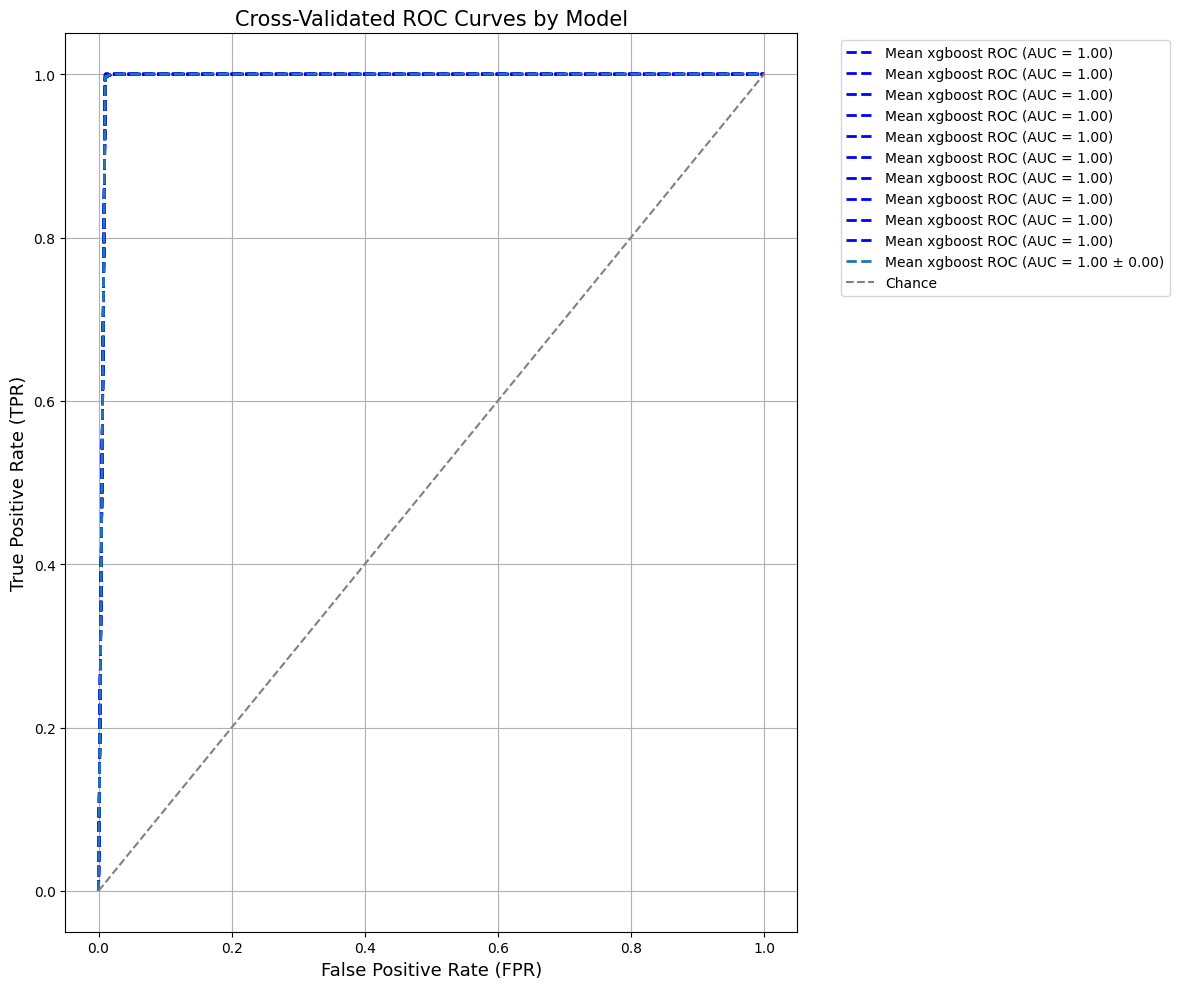

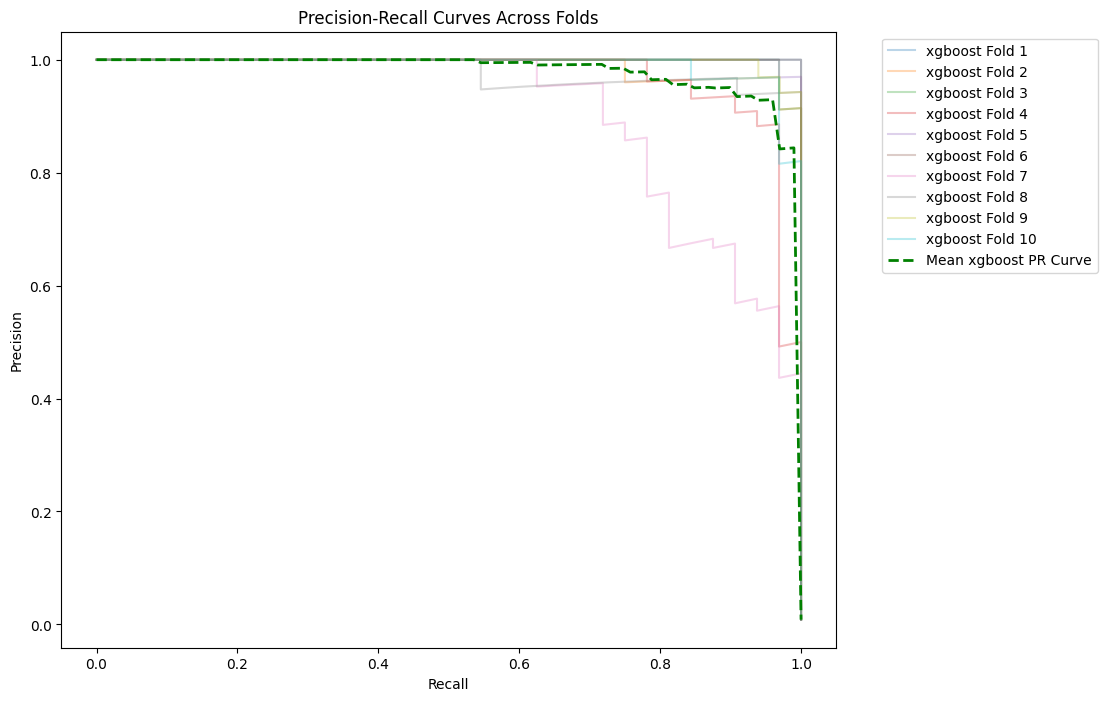

In [28]:
# Set up stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

xgboost_model = XGBoostTrainer(
    scale_pos_weight=1,
    calibrator='sigmoid',
    cv=5
)

# Initialize your KNN model
knn_model = KNNTrainer()
# xgboost_model = XGBoostTrainer(calibrated=True, calibrator='sigmoid', cv=5)

# Create a models dictionary (required by ModelEvaluator)
models = {
    # 'knn': knn_model,
    'xgboost': xgboost_model
}

# Initialize ModelEvaluator with your data and models
evaluator = ModelEvaluator(models=models, X=X, y=y)

# Run the evaluation
evaluator.evaluate_all(cv)
evaluator.plot_roc_curves()
evaluator.plot_precision_recall_curves()

# # Run the evaluation
# evaluator.evaluate_all(cv=cv, verbose=True)

# # Generate comprehensive output
# print("\n\n=== KNN MODEL EVALUATION REPORT ===")
# print("=== Configuration ===")
# print(f"- Training samples: {len(X)}")
# print(f"- Features: {X.shape[1]}")
# print(f"- Target distribution:\n{y.value_counts(normalize=True)}")
# print(f"- Cross-validation: Stratified {cv.n_splits}-fold")

# # Get the evaluation results
# knn_results = evaluator.results['knn']

# print("\n=== Performance Metrics ===")
# print(f"ROC AUC: {knn_results['roc_auc']:.4f} (95% CI: {np.std(evaluator.fold_results['knn']['roc_curves']):.4f})")
# print(f"Average Precision: {knn_results['average_precision']:.4f}")
# print(f"Accuracy: {knn_results['accuracy']:.4f}")
# print(f"F1 Score: {knn_results['f1']:.4f}")
# print(f"Precision: {knn_results['precision']:.4f}")
# print(f"Recall: {knn_results['recall']:.4f}")
# print(f"Cohen's Kappa: {knn_results['cohen_kappa']:.4f}")
# print(f"Matthews Correlation: {knn_results['matthews_corrcoef']:.4f}")
# print(f"Log Loss: {knn_results['log_loss']:.4f}")
# print(f"Brier Score: {knn_results['brier_score_loss']:.4f}")

# # Print classification report
# print("\n=== Classification Report ===")
# class_report = knn_results['classification_report']
# for class_label, metrics in class_report.items():
#     if class_label in ['0', '1']:  # For binary classification
#         print(f"Class {class_label}:")
#         print(f"  Precision: {metrics['precision']:.4f}")
#         print(f"  Recall: {metrics['recall']:.4f}")
#         print(f"  F1-score: {metrics['f1-score']:.4f}")
#         print(f"  Support: {metrics['support']}")

# # Print confusion matrix (average across folds)
# print("\n=== Confusion Matrix ===")
# # Note: The evaluator doesn't average confusion matrices by default
# # So we'll print the first fold's matrix as an example
# first_fold_cm = evaluator.fold_results['knn']['individual_folds'][0]['confusion_matrix']
# print("Example from first fold:")
# print(first_fold_cm)

# # Generate visualizations
# print("\n=== Model Diagnostics ===")
# print("Generating ROC and Precision-Recall curves...")
# evaluator.plot_roc_curves()
# evaluator.plot_precision_recall_curves()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# === 1. Preprocess original dataset ===
preprocessor = ExoplanetDataPreprocessor(exoplanet_df, target_column="habitable")
processed_df = preprocessor.fit_transform(exoplanet_df)

# Separate features and target from processed_df
y = processed_df["is_habitable"]  # Or "habitable" if not renamed
X = processed_df.drop(columns=["is_habitable"])

# === 2. Detect feature types ===
num_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# === 3. Define transformers ===
cat_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
num_imputer = IterativeImputer(
    random_state=42,
    max_iter=20,
    sample_posterior=True,
    initial_strategy='median',
    imputation_order='ascending'
)

# === 4. Combine transformers into ColumnTransformer ===
preprocessing_pipeline = ColumnTransformer([
    ("num", num_imputer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

# === 5. Feature engineering pipeline (optional) ===
eng = ExoplanetFeatureEngineer()
feature_pipeline = eng._create_sk_pipeline()

# === 6. Final pipeline ===
# You may include both feature engineering and preprocessing in one pipeline
full_pipeline = Pipeline([
    ("features", feature_pipeline),        # Applies your custom engineered transformations
    ("preprocessing", preprocessing_pipeline)
])

# === 7. Define models ===
xgboost_model = XGBoostTrainer(
    scale_pos_weight=1,
    calibrator='sigmoid',
    cv=5
)

knn_model = KNNTrainer()

models = {
    # 'knn': knn_model,
    'xgboost': xgboost_model
}

# === 8. Setup cross-validation ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === 9. Fit-transform X inside the pipeline before CV ===
X_transformed = full_pipeline.fit_transform(X)

# === 10. Evaluate ===
evaluator = ModelEvaluator(models=models, X=X_transformed, y=y)
evaluator.evaluate_all(cv)


def map_label(val):
  if "[Fe/H]" in str(val):
    return "iron_indicator"
  elif "[M/H]" in str(val):
    return "metal_indicator"
  else:
    return "unknown"

df['st_metratio_cat'] = df['st_metratio'].apply(map_label)

if "st_metratio" in df.columns:
    df.drop(columns=["st_metratio"], inplace=True)
else:
    print("Column 'st_metratio' already removed or not present.")
df[["st_metratio_cat"]].head(10)